In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in the dataset
full_df= pd.read_csv('Data/full_data_growth_included.csv', index_col=0)
full_df.head()

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,walking gps hits,cases,deaths,Growth Rate,Num New Cases
0,Alabama,2020-03-13,7.0,32.0,26.0,7.0,-2.0,0.0,160.430000,110.95,110.84,6,0,NaN,NaN
1,Alabama,2020-03-14,1.0,28.0,55.0,12.0,4.0,0.0,169.976429,116.64,114.48,12,0,100.000000,6.0
2,Alabama,2020-03-15,-7.0,16.0,16.0,6.0,-4.0,2.0,119.303036,78.24,59.90,23,0,91.666667,11.0
3,Alabama,2020-03-16,-2.0,24.0,22.0,2.0,-10.0,4.0,116.498750,91.18,77.73,29,0,26.086957,6.0
4,Alabama,2020-03-17,-11.0,17.0,25.0,-1.0,-17.0,7.0,107.171250,84.92,72.97,39,0,34.482759,10.0


In [3]:
# Extract California dataset
ca= full_df[full_df['state'] == 'California']
ca.head()

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,walking gps hits,cases,deaths,Growth Rate,Num New Cases
450,California,2020-02-15,1.0,1.0,19.0,1.0,-1.0,0.0,149.625000,98.747059,161.364286,7,0,0.0,0.0
451,California,2020-02-16,5.0,0.0,31.0,1.0,-1.0,-1.0,128.067973,85.542941,127.493810,7,0,0.0,0.0
452,California,2020-02-17,9.0,1.0,44.0,-12.0,-38.0,8.0,131.830676,98.512353,119.583333,7,0,0.0,0.0
453,California,2020-02-18,0.0,0.0,16.0,3.0,0.0,0.0,114.652568,110.847059,109.419524,7,0,0.0,0.0
454,California,2020-02-19,0.0,0.0,13.0,1.0,0.0,0.0,115.025946,110.649412,112.455238,7,0,0.0,0.0


In [4]:
ca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 450 to 581
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  132 non-null    object 
 1   date                   132 non-null    object 
 2   retail_and_recreation  132 non-null    float64
 3   grocery_and_pharmacy   132 non-null    float64
 4   parks                  132 non-null    float64
 5   transit                132 non-null    float64
 6   workplace              132 non-null    float64
 7   residential            132 non-null    float64
 8   driving gps hits       132 non-null    float64
 9   transit gps hits       132 non-null    float64
 10  walking gps hits       132 non-null    float64
 11  cases                  132 non-null    int64  
 12  deaths                 132 non-null    int64  
 13  Growth Rate            132 non-null    float64
 14  Num New Cases          132 non-null    float64
dtypes: f

In [5]:
ca_start_date= ca.date.min()
ca_end_date= ca.date.max()
print('The California data starts on {} and runs through {}.'.format(ca_start_date, ca_end_date))

The California data starts on 2020-02-15 and runs through 2020-06-27.


### Vanilla Linear Regression

In [6]:
# We will do a manual train and test split of the data. Because there are 132 days in the dataset I will use the first
# 93 days for training (70%) and the rest of the days for testing 
x_train= ca[:93].drop(columns=['state', 'date', 'cases', 'deaths', 'Growth Rate', 'Num New Cases'])
x_test= ca[93:].drop(columns=['state', 'date', 'cases', 'deaths', 'Growth Rate', 'Num New Cases'])
y_train= pd.DataFrame(ca['Num New Cases'][:93])
y_test= pd.DataFrame(ca['Num New Cases'][93:])

In [7]:
# scaling data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(x_test.shape)

(93, 9)
(39, 9)


In [8]:
vanilla_lin= linear_model.LinearRegression()
vanilla_lin.fit(x_train, y_train)
r2_train= vanilla_lin.score(x_train, y_train)
r2_test= vanilla_lin.score(x_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))


R2 TRAIN: 0.6844749342255709
R2 TEST: -1.9004468441622522


In [9]:
from sklearn.metrics import mean_absolute_error
y_pred_train= vanilla_lin.predict(x_train)
y_pred_test= vanilla_lin.predict(x_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))


MAE TRAIN: 309.30587237721176
MAE TEST: 1541.3684886536566


### Lasso Regression

We were severly overfitting prior so we will use Lasso Regression and see what happens

In [10]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for a in alpha:
    lasso= linear_model.Lasso(alpha=a)
    lasso.fit(x_train, y_train)
    r2_train= lasso.score(x_train, y_train)
    r2_test= lasso.score(x_test, y_test)
    y_pred_train= lasso.predict(x_train)
    y_pred_test= lasso.predict(x_test)
    mae_train= mean_absolute_error(y_train, y_pred_train)
    mae_test= mean_absolute_error(y_test, y_pred_test)
    print('Alpha of {} gives us a Training R2 of {}'.format(a, r2_train))
    print('Alpha of {} gives us a Testing R2 of {}'.format(a, r2_test))
    print('Alpha of {} gives us a Training MAE of {}'.format(a, mae_train))
    print('Alpha of {} gives us a Testing MAE of {}'.format(a, mae_test))
    print('\n')

Alpha of 0.001 gives us a Training R2 of 0.6844749326992412
Alpha of 0.001 gives us a Testing R2 of -1.8999885783269637
Alpha of 0.001 gives us a Training MAE of 309.301712245333
Alpha of 0.001 gives us a Testing MAE of 1541.2201710255026


Alpha of 0.01 gives us a Training R2 of 0.6844747831148303
Alpha of 0.01 gives us a Testing R2 of -1.8958894230573444
Alpha of 0.01 gives us a Training MAE of 309.26450181011006
Alpha of 0.01 gives us a Testing MAE of 1539.893185488456


Alpha of 0.1 gives us a Training R2 of 0.6844598307576362
Alpha of 0.1 gives us a Testing R2 of -1.8550948492113375
Alpha of 0.1 gives us a Training MAE of 308.9048901928217
Alpha of 0.1 gives us a Testing MAE of 1526.6193875168874


Alpha of 1 gives us a Training R2 of 0.6835930207531372
Alpha of 1 gives us a Testing R2 of -1.5537666101545962
Alpha of 1 gives us a Training MAE of 307.8792923332952
Alpha of 1 gives us a Testing MAE of 1426.2088492874593


Alpha of 10 gives us a Training R2 of 0.6728103706983325
Alph

/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20881.682489156723, tolerance: 7193.39947311828
  positive)


### Adding a Time Feature

Vanilla Linear Regress

With a time feature

In [11]:
ca.shape

(132, 15)

In [12]:
ca['Day']= range(1,133)
ca.head()
ca.tail()

/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,walking gps hits,cases,deaths,Growth Rate,Num New Cases,Day
577,California,2020-06-23,-29.0,-7.0,14.0,-38.0,-42.0,14.0,142.186081,48.518235,139.011429,191039,5637,3.476871,6419.0,128
578,California,2020-06-24,-29.0,-8.0,9.0,-39.0,-41.0,14.0,146.346757,51.071176,140.445238,195889,5728,2.538749,4850.0,129
579,California,2020-06-25,-29.0,-7.0,7.0,-39.0,-41.0,14.0,153.047703,51.350588,147.294762,201413,5810,2.819964,5524.0,130
580,California,2020-06-26,-31.0,-7.0,7.0,-39.0,-40.0,14.0,177.028378,53.797059,166.309524,207027,5872,2.787308,5614.0,131
581,California,2020-06-27,-33.0,-6.0,6.0,-32.0,-16.0,7.0,176.721892,49.085882,169.126190,211453,5902,2.137885,4426.0,132


In [13]:
X= ca.drop(columns=['state', 'date', 'cases', 'deaths', 'Growth Rate', 'Num New Cases'])
y= ca['Num New Cases']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 42)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
            

(92, 10)
(92,)
(40, 10)
(40,)


In [14]:
linear= linear_model.LinearRegression()
linear.fit(X_train, y_train)
r2_train= linear.score(X_train, y_train)
r2_test= linear.score(X_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))

R2 TRAIN: 0.8757626435062812
R2 TEST: 0.8476619774517316


In [15]:
y_pred_train= linear.predict(X_train)
y_pred_test= linear.predict(X_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))


MAE TRAIN: 322.7080101580196
MAE TEST: 388.2772875859074


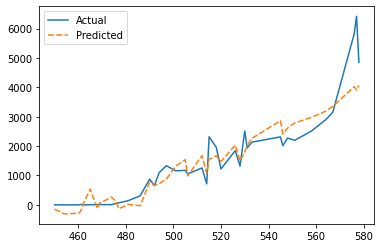

In [16]:
df= pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
df= df.sort_values(by='Actual')

sns.lineplot(data= df)


Text(0.5, 1.0, 'Residual Plot')

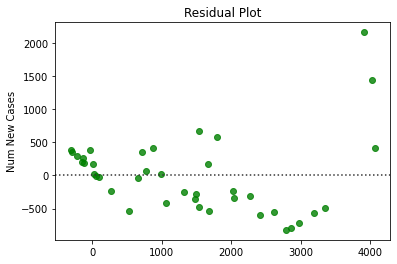

In [17]:
sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot')

In [18]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for a in alpha:
    lasso= linear_model.Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    r2_train= lasso.score(X_train, y_train)
    r2_test= lasso.score(X_test, y_test)
    y_pred_train= lasso.predict(X_train)
    y_pred_test= lasso.predict(X_test)
    mae_train= mean_absolute_error(y_train, y_pred_train)
    mae_test= mean_absolute_error(y_test, y_pred_test)
    print('Alpha of {} gives us a Training R2 of {}'.format(a, r2_train))
    print('Alpha of {} gives us a Testing R2 of {}'.format(a, r2_test))
    print('Alpha of {} gives us a Training MAE of {}'.format(a, mae_train))
    print('Alpha of {} gives us a Testing MAE of {}'.format(a, mae_test))
    print('\n')

Alpha of 0.001 gives us a Training R2 of 0.8757626431771345
Alpha of 0.001 gives us a Testing R2 of 0.8476615970382517
Alpha of 0.001 gives us a Training MAE of 322.70586372638894
Alpha of 0.001 gives us a Testing MAE of 388.27025514550775


Alpha of 0.01 gives us a Training R2 of 0.8757626105120364
Alpha of 0.01 gives us a Testing R2 of 0.8476585080302269
Alpha of 0.01 gives us a Training MAE of 322.6900508183908
Alpha of 0.01 gives us a Testing MAE of 388.2058905332201


Alpha of 0.1 gives us a Training R2 of 0.8757592198903801
Alpha of 0.1 gives us a Testing R2 of 0.8476275535921318
Alpha of 0.1 gives us a Training MAE of 322.55572846073323
Alpha of 0.1 gives us a Testing MAE of 387.5404201572678


Alpha of 1 gives us a Training R2 of 0.8754168610620805
Alpha of 1 gives us a Testing R2 of 0.8469121732499738
Alpha of 1 gives us a Training MAE of 321.3652092669596
Alpha of 1 gives us a Testing MAE of 381.40997418940054


Alpha of 10 gives us a Training R2 of 0.8671340915740574
Alpha o

### Introducing Lagging Variables

In [19]:
lagged_df= ca.copy()

mobility_markers= []
for x in lagged_df.columns[2:11]:
    mobility_markers.append(x)

for marker in mobility_markers:
    lagged_df['{}_14_lag'.format(marker)]= lagged_df[marker].shift(13)

for marker in mobility_markers:
    lagged_df['{}_7_lag'.format(marker)]= lagged_df[marker].shift(6)
    





In [20]:
lagged_df.head(16)

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,...,walking gps hits_14_lag,retail_and_recreation_7_lag,grocery_and_pharmacy_7_lag,parks_7_lag,transit_7_lag,workplace_7_lag,residential_7_lag,driving gps hits_7_lag,transit gps hits_7_lag,walking gps hits_7_lag
450,California,2020-02-15,1.0,1.0,19.0,1.0,-1.0,0.0,149.625000,98.747059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,California,2020-02-16,5.0,0.0,31.0,1.0,-1.0,-1.0,128.067973,85.542941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
452,California,2020-02-17,9.0,1.0,44.0,-12.0,-38.0,8.0,131.830676,98.512353,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,California,2020-02-18,0.0,0.0,16.0,3.0,0.0,0.0,114.652568,110.847059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
454,California,2020-02-19,0.0,0.0,13.0,1.0,0.0,0.0,115.025946,110.649412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,California,2020-02-20,2.0,1.0,12.0,1.0,0.0,0.0,120.621216,108.973529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
456,California,2020-02-21,1.0,0.0,8.0,0.0,1.0,0.0,143.535541,117.529412,...,NaN,1.0,1.0,19.0,1.0,-1.0,0.0,149.625000,98.747059,161.364286
457,California,2020-02-22,0.0,0.0,-3.0,-4.0,1.0,1.0,142.735676,97.484118,...,NaN,5.0,0.0,31.0,1.0,-1.0,-1.0,128.067973,85.542941,127.493810
458,California,2020-02-23,4.0,1.0,16.0,3.0,2.0,0.0,119.011486,88.245294,...,NaN,9.0,1.0,44.0,-12.0,-38.0,8.0,131.830676,98.512353,119.583333
459,California,2020-02-24,2.0,0.0,12.0,1.0,4.0,0.0,111.661351,109.474706,...,NaN,0.0,0.0,16.0,3.0,0.0,0.0,114.652568,110.847059,109.419524


In [21]:
lagged_df.tail()

,state,date,retail_and_recreation,grocery_and_pharmacy,parks,transit,workplace,residential,driving gps hits,transit gps hits,...,walking gps hits_14_lag,retail_and_recreation_7_lag,grocery_and_pharmacy_7_lag,parks_7_lag,transit_7_lag,workplace_7_lag,residential_7_lag,driving gps hits_7_lag,transit gps hits_7_lag,walking gps hits_7_lag
577,California,2020-06-23,-29.0,-7.0,14.0,-38.0,-42.0,14.0,142.186081,48.518235,...,127.602857,-29.0,-6.0,12.0,-38.0,-41.0,14.0,138.033243,48.544706,133.660000
578,California,2020-06-24,-29.0,-8.0,9.0,-39.0,-41.0,14.0,146.346757,51.071176,...,128.171905,-28.0,-5.0,9.0,-39.0,-41.0,14.0,144.383514,49.880000,136.799048
579,California,2020-06-25,-29.0,-7.0,7.0,-39.0,-41.0,14.0,153.047703,51.350588,...,148.438571,-30.0,-4.0,9.0,-38.0,-40.0,12.0,169.186622,50.734118,160.095238
580,California,2020-06-26,-31.0,-7.0,7.0,-39.0,-40.0,14.0,177.028378,53.797059,...,156.544286,-31.0,1.0,6.0,-32.0,-14.0,7.0,167.330946,45.618235,160.411429
581,California,2020-06-27,-33.0,-6.0,6.0,-32.0,-16.0,7.0,176.721892,49.085882,...,124.569524,-32.0,-4.0,10.0,-34.0,-14.0,5.0,138.287973,38.910588,115.440476


In [22]:
lagged_df.columns

Index(['state', 'date', 'retail_and_recreation', 'grocery_and_pharmacy',
       'parks', 'transit', 'workplace', 'residential', 'driving gps hits',
       'transit gps hits', 'walking gps hits', 'cases', 'deaths',
       'Growth Rate', 'Num New Cases', 'Day', 'retail_and_recreation_14_lag',
       'grocery_and_pharmacy_14_lag', 'parks_14_lag', 'transit_14_lag',
       'workplace_14_lag', 'residential_14_lag', 'driving gps hits_14_lag',
       'transit gps hits_14_lag', 'walking gps hits_14_lag',
       'retail_and_recreation_7_lag', 'grocery_and_pharmacy_7_lag',
       'parks_7_lag', 'transit_7_lag', 'workplace_7_lag', 'residential_7_lag',
       'driving gps hits_7_lag', 'transit gps hits_7_lag',
       'walking gps hits_7_lag'],
      dtype='object')

In [23]:
lagged_df.dropna(inplace=True)
X= lagged_df.iloc[:,-19:]
y= lagged_df['Num New Cases']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 42)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(83, 19)
(83,)
(36, 19)
(36,)


In [24]:
linear= linear_model.LinearRegression()
linear.fit(X_train, y_train)
r2_train= linear.score(X_train, y_train)
r2_test= linear.score(X_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))

R2 TRAIN: 0.8841388518489011
R2 TEST: 0.7178868560000211


In [25]:
y_pred_train= linear.predict(X_train)
y_pred_test= linear.predict(X_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))

MAE TRAIN: 326.9197997199384
MAE TEST: 452.6745060777308


In [26]:
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
for a in alpha:
    lasso= linear_model.Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    r2_train= lasso.score(X_train, y_train)
    r2_test= lasso.score(X_test, y_test)
    y_pred_train= lasso.predict(X_train)
    y_pred_test= lasso.predict(X_test)
    mae_train= mean_absolute_error(y_train, y_pred_train)
    mae_test= mean_absolute_error(y_test, y_pred_test)
    print('Alpha of {} gives us a Training R2 of {}'.format(a, r2_train))
    print('Alpha of {} gives us a Testing R2 of {}'.format(a, r2_test))
    print('Alpha of {} gives us a Training MAE of {}'.format(a, mae_train))
    print('Alpha of {} gives us a Testing MAE of {}'.format(a, mae_test))
    print('\n')

Alpha of 0.001 gives us a Training R2 of 0.8841373676169467
Alpha of 0.001 gives us a Testing R2 of 0.7186273558589731
Alpha of 0.001 gives us a Training MAE of 326.6691567207155
Alpha of 0.001 gives us a Testing MAE of 452.46822781349863


Alpha of 0.01 gives us a Training R2 of 0.884136673327365
Alpha of 0.01 gives us a Testing R2 of 0.7189796771362416
Alpha of 0.01 gives us a Training MAE of 326.60198887260805
Alpha of 0.01 gives us a Testing MAE of 452.29162143456114


Alpha of 0.1 gives us a Training R2 of 0.8841156217488159
Alpha of 0.1 gives us a Testing R2 of 0.7224703445530333
Alpha of 0.1 gives us a Training MAE of 325.93041745205255
Alpha of 0.1 gives us a Testing MAE of 450.5256412408467


Alpha of 1 gives us a Training R2 of 0.8827008605619006
Alpha of 1 gives us a Testing R2 of 0.7519530290649277
Alpha of 1 gives us a Training MAE of 321.02101532238515
Alpha of 1 gives us a Testing MAE of 434.5551171914617


Alpha of 10 gives us a Training R2 of 0.8629554392752935
Alpha o

/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8904710.031454697, tolerance: 15830.01778795181
  positive)
/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6947715.772609495, tolerance: 15830.01778795181
  positive)
/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1400953.7648997884, tolerance: 15830.01778795181
  positive)
/Users/jeremysilva/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not con

In [27]:
alpha = [60, 80, 100, 120, 140, 200, 300]
for a in alpha:
    lasso= linear_model.Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    r2_train= lasso.score(X_train, y_train)
    r2_test= lasso.score(X_test, y_test)
    y_pred_train= lasso.predict(X_train)
    y_pred_test= lasso.predict(X_test)
    mae_train= mean_absolute_error(y_train, y_pred_train)
    mae_test= mean_absolute_error(y_test, y_pred_test)
    print('Alpha of {} gives us a Training R2 of {}'.format(a, r2_train))
    print('Alpha of {} gives us a Testing R2 of {}'.format(a, r2_test))
    print('Alpha of {} gives us a Training MAE of {}'.format(a, mae_train))
    print('Alpha of {} gives us a Testing MAE of {}'.format(a, mae_test))
    print('\n')

Alpha of 60 gives us a Training R2 of 0.8301934334221801
Alpha of 60 gives us a Testing R2 of 0.7958206277392829
Alpha of 60 gives us a Training MAE of 386.6464272907746
Alpha of 60 gives us a Testing MAE of 394.7243160372199


Alpha of 80 gives us a Training R2 of 0.8186180439568579
Alpha of 80 gives us a Testing R2 of 0.7954515810178211
Alpha of 80 gives us a Training MAE of 404.4919442229366
Alpha of 80 gives us a Testing MAE of 408.48587943682446


Alpha of 100 gives us a Training R2 of 0.8132242012248885
Alpha of 100 gives us a Testing R2 of 0.7931354291169825
Alpha of 100 gives us a Training MAE of 408.7207749832444
Alpha of 100 gives us a Testing MAE of 415.10292931871464


Alpha of 120 gives us a Training R2 of 0.8096193260000273
Alpha of 120 gives us a Testing R2 of 0.78994952747082
Alpha of 120 gives us a Training MAE of 409.057104418794
Alpha of 120 gives us a Testing MAE of 418.4369898074775


Alpha of 140 gives us a Training R2 of 0.8055648378341895
Alpha of 140 gives us a

In [28]:
lasso= linear_model.Lasso(alpha= 80)

lasso.fit(X_train, y_train)
r2_train= lasso.score(X_train, y_train)
r2_test= lasso.score(X_test, y_test)
print('R2 TRAIN: {}'.format(r2_train))
print('R2 TEST: {}'.format(r2_test))
print('\n')

y_pred_train= lasso.predict(X_train)
y_pred_test= lasso.predict(X_test)
mae_train= mean_absolute_error(y_train, y_pred_train)
mae_test= mean_absolute_error(y_test, y_pred_test)
print('MAE TRAIN: {}'.format(mae_train))
print('MAE TEST: {}'.format(mae_test))


R2 TRAIN: 0.8186180439568579
R2 TEST: 0.7954515810178211


MAE TRAIN: 404.4919442229366
MAE TEST: 408.48587943682446


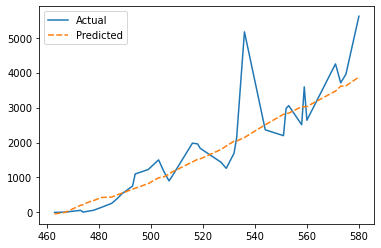

Text(0.5, 1.0, 'Residual Plot')

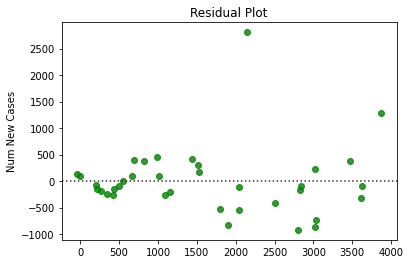

In [29]:
df= pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
df= df.sort_values(by='Actual')

sns.lineplot(data= df)
plt.show()

sns.residplot(y_pred_test, y_test, color="g")
plt.title('Residual Plot')

In [30]:
df

,Actual,Predicted
463,1.0,-43.089424
467,7.0,-1.051520
474,7.0,219.245305
475,23.0,265.072651
473,60.0,203.392416
478,61.0,338.994989
481,144.0,427.371839
485,261.0,440.293999
487,389.0,501.366953
489,539.0,554.161866


### Using PCA to Uncorrelate Features

In [34]:
# Borrowing from https://medium.com/towards-artificial-intelligence/training-a-machine-learning-model-on-a-dataset-with-highly-correlated-features-debddf5b2e34
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

train_score = []
test_score = []
cum_variance = []

linear= linear_model.LinearRegression()

for i in range(1,5):
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=42)
    y_train_std = scaler.fit_transform(y_train[:, np.newaxis]).flatten()
    
    pipe_lr = Pipeline([('scl', StandardScaler()),
                        ('pca', PCA(n_components=i)),
                        ('slr',   LinearRegression())]) 
    pipe_lr.fit(X_train, y_train_std)
    y_train_pred_std = pipe_lr.predict(X_train)
    y_test_pred_std = pipe_lr.predict(X_test)
    y_train_pred=scaler.inverse_transform(y_train_pred_std)
    y_test_pred=scaler.inverse_transform(y_test_pred_std)
    train_score = np.append(train_score, 
                            r2_score(y_train, y_train_pred))
    test_score = np.append(test_score, 
                           r2_score(y_test, y_test_pred))
    cum_variance = np.append(cum_variance, np.sum(pipe_lr.fit(X_train, y_train).named_steps['pca'].explained_variance_ratio_))

In [35]:
train_score

array([0.06561364, 0.77906565, 0.79179621, 0.80017273])

In [36]:
test_score

array([0.08405636, 0.73999101, 0.74564657, 0.76614583])

In [37]:
cum_variance

array([0.69612673, 0.86163233, 0.91033763, 0.93838881])